<a href="https://colab.research.google.com/github/1900690/gazou-gousei/blob/main/%E7%94%BB%E5%83%8F%E5%90%88%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#使用方法
*   「二つの画像を重ね合わせて表示する」では、スクリーンショット (3).pngを押し、**ファイル選択**を押してアップロードする画像を選択する。
*   「二つの画像の変化点を白黒画像で表示」では、スクリーンショット (3).pngを押す。

Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg


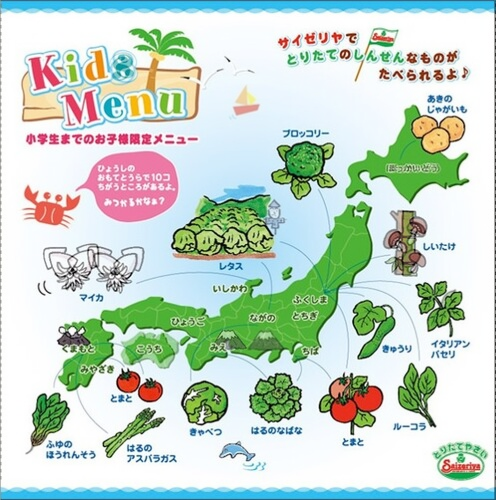

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#@title 二つの画像を重ね合わせて表示する
#@markdown ※画像のサイズを合わせてください

#@markdown [詳しい仕組みを知りたい場合はここをクリック](https://campkougaku.com/2020/04/15/alignment/#toc2)

#★関数定義
import cv2
import numpy as np
def get_keypoints(img, pt1 = (0, 0), pt2 = None):

    if pt2 is None:
        pt2 = (img.shape[1], img.shape[0])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = cv2.rectangle(np.zeros_like(gray), pt1, pt2, color=1, thickness=-1)
    sift = cv2.AKAZE_create()

    # find the key points and descriptors with AKAZE
    return sift.detectAndCompute(gray, mask=mask)

def get_matcher(img, kp2, des2):

    kp1, des1 = get_keypoints(img)

    if len(kp1) == 0 or len(kp2) == 0:
        return None

    # Brute-Force Matcher生成
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    if len(good) == 0:
        return None

    target_position = []
    base_position = []
    # x,y座標の取得
    for g in good:
        target_position.append([kp1[g.queryIdx].pt[0], kp1[g.queryIdx].pt[1]])
        base_position.append([kp2[g.trainIdx].pt[0], kp2[g.trainIdx].pt[1]])

    apt1 = np.array(target_position)
    apt2 = np.array(base_position)
    return apt1, apt2

def get_alignment_img(img, kp2, des2):

    height, width = img.shape[:2]
    # 対応点を探索
    apt1, apt2 = get_matcher(img, kp2, des2)

    # アフィン行列の推定
    mtx = cv2.estimateAffinePartial2D(apt1, apt2)[0]

    # アフィン変換
    if mtx is not None:
        return cv2.warpAffine(img, mtx, (width, height))
    else:
        return None

#★画像のアップロード
import shutil
import os
import glob


#データを入れるためのフォルダを作成（すでにフォルダがある場合は消去する）
if os.path.exists('/content/slice'):
  shutil.rmtree('/content/slice')
if not os.path.exists('/content/slice'):
    os.makedirs('/content/slice')
if os.path.exists('/content/alignment'):
  shutil.rmtree('/content/alignment')


#カレントディレクトリを移動
%cd -q '/content/slice/'

#データをアップロード
from google.colab import files
uploaded = files.upload()

#ファイルをまとめてリネーム
path = '/content/slice/'
files = glob.glob(path + '/*')
for f in files:
    os.rename(f, os.path.join(path, 'img_' + os.path.basename(f)))

#元のディレクトリに戻る
%cd -q '/content/'

#★一つ目の画像に合わせて位置合わせを行う
from PIL import Image
import numpy as np
import shutil
import glob


#画像のリストを取得
os.chdir("/content/slice")
path = glob.glob("*")

#保存用フォルダを作成
SAVE_NAME = 'alignment'
if not os.path.exists('/content/' +SAVE_NAME):
    os.mkdir('/content/' +SAVE_NAME)

base = np.array(Image.open("/content/slice/"+path[0]), dtype=np.uint8)#元画像

for i in range(len(path)-1):
  frame = np.array(Image.open("/content/slice/"+path[i+1]), dtype=np.uint8)#位置合わせする画像
  kp, des = get_keypoints(base)
  align = get_alignment_img(frame, kp, des)
  Image.fromarray(align).save("/content/alignment/aligned_"+path[i+1], "JPEG", quality=95)

shutil.copy("/content/slice/"+path[0],"/content/alignment/"+path[0])

#★画像を合成して結果を出力
import cv2
import glob
import os
from google.colab.patches import cv2_imshow

#階層移動
os.chdir("/content/alignment")
#階層内のPathを全取得
path = glob.glob("*")
#print(path)

#一枚目と二枚目を合成
dst=cv2.addWeighted(cv2.imread(path[0]), 1/len(path), cv2.imread(path[1]), 1/len(path), 0)

#残りを合成
for number in list(range(2,len(path))):
  src = cv2.imread(path[number])
  #src = cv2.resize(src, dst.shape[1::-1])#サイズを合わせる必要があるなら
  dst=cv2.addWeighted(dst,1, src, 1/len(path), 0)

#書き出し
cv2.imwrite("/content/result.jpg", dst)
#表示する場合
cv2_imshow(dst)

#結果をダウンロード
import os
from google.colab import files

files.download("/content/result.jpg")

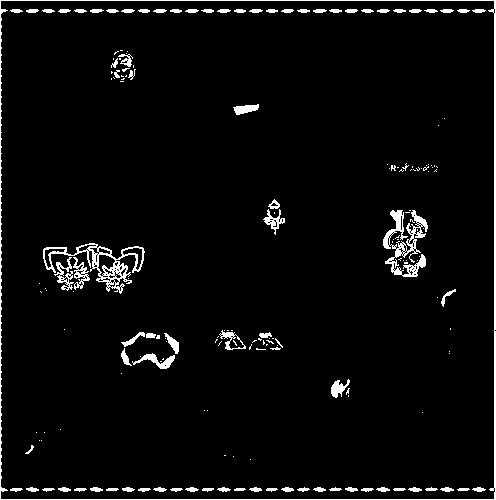

In [8]:
#@title 二つの画像の変化点を白黒画像で表示
import cv2
from google.colab.patches import cv2_imshow

#画像のリストを取得
os.chdir("/content/alignment")
path = glob.glob("*")

#「背景」となる画像の取り込み（グレースケール）
img_src01 = cv2.imread("/content/alignment/"+path[0], 0)

#「差分」をもった画像の取り込み（グレースケール）
img_src02 = cv2.imread("/content/alignment/"+path[1], 0)

#「背景差分」計算用オブジェクトの作成
bgObj = cv2.bgsegm.createBackgroundSubtractorMOG()

#差分となっている「前景領域」に対してマスクをかける
fgmask = bgObj.apply(img_src01)
fgmask = bgObj.apply(img_src02)

#画面に表示
cv2_imshow(fgmask)

#「差分」画像のファイル名
bg_diff_path = "/content/diff.jpg"

#「差分」画像の保存
cv2.imwrite(bg_diff_path, fgmask)

#「キー」が押されるまで画面を表示
cv2.waitKey(0)

#作成した画面をすべて破棄
cv2.destroyAllWindows()